# Imports and defs

In [1]:
SEED = 123
CTX = 'Bank_Marketing_Case_v3_'

In [2]:
import os
import numpy as np
import pandas as pd
import sklearn as skl
import xgboost as xgb
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 200)
np.set_printoptions(edgeitems=100)

#import matplotlib as mpl
import matplotlib.pyplot as plt
#import matplotlib.dates as mdates
%matplotlib inline 

from tqdm import tqdm_notebook
from itertools import product

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

#import gc

In [3]:
for p in [np, pd, skl, xgb]:
    print (p.__name__, p.__version__)

numpy 1.15.4
pandas 0.23.4
sklearn 0.20.1
xgboost 0.81


In [4]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score

def score(est, ground_truths, predictions):
    print(est)
    print('Accuracy is %f' % accuracy_score(ground_truths, predictions))
    print('ROC AUC is %f' % roc_auc_score(ground_truths, predictions))
    print('Precision is %f' % precision_score(ground_truths, predictions))
    print('Recall is %f' % recall_score(ground_truths, predictions))    

In [5]:
import h5py

CACHE_FOLDER = './cache/'
KEY = 'dataset_1'

def save_data(filename, data):
    path = str(os.path.join(CACHE_FOLDER, filename) + '.h5')
    print('Saving ' + path)
    if isinstance(data, pd.DataFrame):
        data.to_hdf(path, KEY, mode='w')
    elif isinstance(data, np.ndarray):
        with h5py.File(path, 'w') as f:
            f.create_dataset(KEY, data=data)
    else:
        raise('Not supported')
    
def load_data(filename, hint):
    path = str(os.path.join(CACHE_FOLDER, filename) + '.h5')
    print('Loading ' + path)
    if isinstance(hint, pd.DataFrame):
        data = pd.read_hdf(path, KEY)
    elif isinstance(hint, np.ndarray):
        with h5py.File(path,'r') as f:
            data = f[KEY][:]
    else:
        raise('Not supported')
        
    return data

In [6]:
from joblib import dump, load
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model as keras_load_model

MODEL_FOLDER = './models/'

def save_model(filename, model):
    path = str(os.path.join(MODEL_FOLDER, filename) + '.jlib')
    print('Saving ' + path)    
    if isinstance(model, KerasClassifier):
        model.model.save(path)
    else:
        dump(model, path)        
        
def load_model(filename, hint):
    path = str(os.path.join(MODEL_FOLDER, filename) + '.jlib')
    print('Loading ' + path)
    if isinstance(hint, KerasClassifier):
        model = keras_load_model(path)
    else:
        model = load(path)
        
    return model        

Using TensorFlow backend.


# Explore Data

Bank Marketing Dataset Description

Goal: The binary classification goal is to predict if the customer will subscribe to a specific financial product (variable '21 target').

Input variables:

* 1  age                       age of the customer
* 2  occupation                type of job
* 3  marital_status            marital status
* 4  education                 type of education
* 5  has_credit                customer has credit by default
* 6  housing_loan              customer has housing loan
* 7  personal_loan             customer has personal loan
* 8  contact_mode              contact communication mode
* 9  month                     last contact month of year
* 10 week_day                  last contact day of the week
* 11 last_contact_duration     last contact duration, in seconds
* 12 contacts_per_campaign     number of contacts performed during this campaign and for this customer
* 13 N_last_days               number of days elapsed after the customer was last contacted for previous campaign
* 14 nb_previous_contact       number of contacts performed before this campaign and for this customer
* 15 previous_outcome          outcome of the previous marketing campaign
* 16 emp_var_rate              employment variation rate (quarterly indicator)
* 17 cons_price_index          consumer price index (monthly indicator)
* 18 cons_conf_index           consumer confidence index (monthly indicator)
* 19 euri_3_month              3 month rate (daily indicator)
* 20 nb_employees              number of employees (quaterly indicator)

Output variable:

* 21 target                    has the client subscribed to a specific financial product

In [7]:
DATA_FOLDER = './data/'

raw = pd.read_csv(os.path.join(DATA_FOLDER, 'bank_dataset.csv'))
raw.head()

,age,occupation,marital_status,education,has_credit,housing_loan,personal_loan,contact_mode,month,week_day,last_contact_duration,contacts_per_campaign,N_last_days,nb_previous_contact,previous_outcome,emp_var_rate,cons_price_index,cons_conf_index,euri_3_month,nb_employees,target
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Quick inspection of feature domains

In [8]:
raw.occupation.unique()

array(['housemaid', 'services', 'admin.', 'blue-collar', 'technician',
       'retired', 'management', 'unemployed', 'self-employed', 'unknown',
       'entrepreneur', 'student'], dtype=object)

In [9]:
raw.marital_status.unique()

array(['married', 'single', 'divorced', 'unknown'], dtype=object)

In [10]:
raw.education.unique()

array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', 'unknown', 'university.degree',
       'illiterate'], dtype=object)

In [11]:
raw.has_credit.unique()

array(['no', 'unknown', 'yes'], dtype=object)

In [12]:
raw.housing_loan.unique()

array(['no', 'yes', 'unknown'], dtype=object)

In [13]:
raw.personal_loan.unique()

array(['no', 'yes', 'unknown'], dtype=object)

In [14]:
raw.contact_mode.unique()

array(['telephone', 'cellular'], dtype=object)

In [15]:
print(raw.month.nunique())
raw.month.unique()

10


array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'mar', 'apr',
       'sep'], dtype=object)

In [16]:
raw.week_day.unique()

array(['mon', 'tue', 'wed', 'thu', 'fri'], dtype=object)

In [17]:
raw.previous_outcome.unique()

array(['nonexistent', 'failure', 'success'], dtype=object)

In [18]:
raw.target.unique()

array(['no', 'yes'], dtype=object)

In [19]:
raw.describe()

,age,last_contact_duration,contacts_per_campaign,N_last_days,nb_previous_contact,emp_var_rate,cons_price_index,cons_conf_index,euri_3_month,nb_employees
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [20]:
raw.isnull().describe()

,age,occupation,marital_status,education,has_credit,housing_loan,personal_loan,contact_mode,month,week_day,last_contact_duration,contacts_per_campaign,N_last_days,nb_previous_contact,previous_outcome,emp_var_rate,cons_price_index,cons_conf_index,euri_3_month,nb_employees,target
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188


Data is quite clean.

No "hard" missing values. N_last_days looks like using 999 to code for infinity, and nb_previous_contact would be 0 for the same records. Some categorical features use 'unknown' as soft indicator for missing value.


## Quick plotting of features

In [21]:
def quick_plot_numeric(fig_num, df, feature_name):
    feature_values = df.loc[:,feature_name]
    plt.figure(fig_num, figsize=(18,9))
    #plt.suptitle(feature.name)
    
    plt.subplot(311)
    plt.plot(feature_values, '.')
    plt.xlabel('Index')
    plt.ylabel(feature_name)
    
    plt.subplot(312)
    to_scatter = df.groupby([feature_name, 'target']).size().reset_index().rename(columns={0:'c'})
    to_scatter['s'] = (to_scatter.c / to_scatter.c.max()) * 100
    #plt.scatter(x=feature_values, df.target, size=count)
    sc = plt.scatter(x=feature_name, y='target', s='s', c='c', cmap=plt.cm.get_cmap('seismic'), data=to_scatter)
    plt.colorbar(sc)
    plt.xlabel(feature_name)
    plt.ylabel('Target')
    
    plt.subplot(313)
    plt.hist(feature_values, bins=100) #TODO: bins?
    plt.xlabel(feature_name)
    plt.ylabel('Count')
    plt.show()
    
def quick_plot_categorical(fig_num, df, feature_name):
    feature_values = df.loc[:,feature_name]
    plt.figure(fig_num, figsize=(18,9))
    #plt.suptitle(feature_name)
    
    # 311
    plt.subplot(211)
    plt.scatter(range(len(feature_values)),feature_values)
    plt.xlabel('Count')    
    plt.ylabel(feature_name)
    
    #312
    plt.subplot(212)
    to_scatter = df.groupby([feature_name, 'target']).size().reset_index().rename(columns={0:'c'})
    to_scatter['s'] = (to_scatter.c / to_scatter.c.max()) * 200
    sc = plt.scatter(x=feature_name, y='target', s='s', c='c', cmap=plt.cm.get_cmap('seismic'), data=to_scatter)
    plt.colorbar(sc)
    plt.xlabel(feature_name)
    plt.ylabel('Target')
    plt.show()
    
    # 313
    df[feature_name].value_counts().plot(kind='bar')

### Age

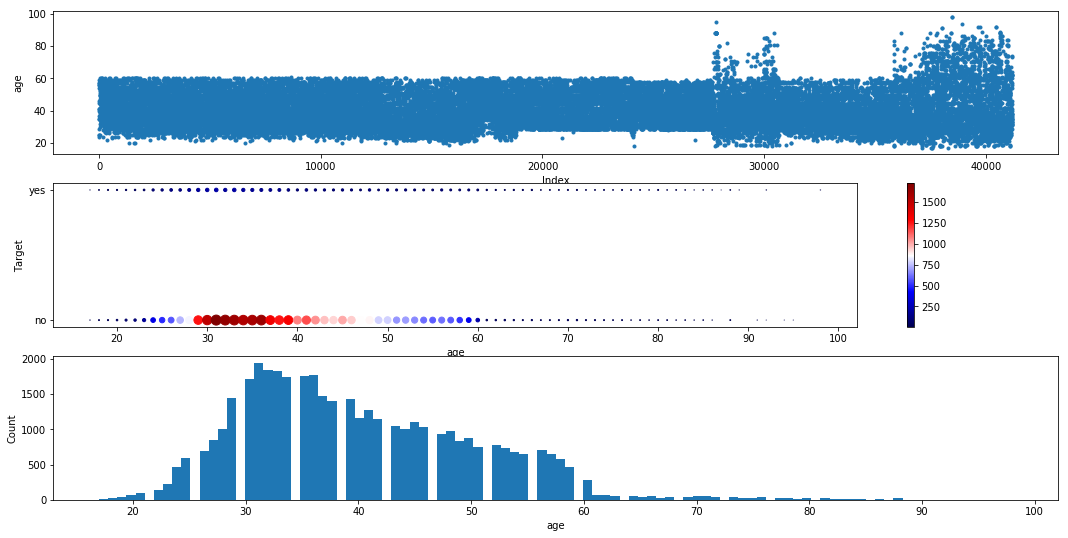

In [22]:
quick_plot_numeric(1, raw, 'age')

The data needs to be shuffled before splitting into train and test to avoid distribution of age becoming different between the two datasets.

### Occupation

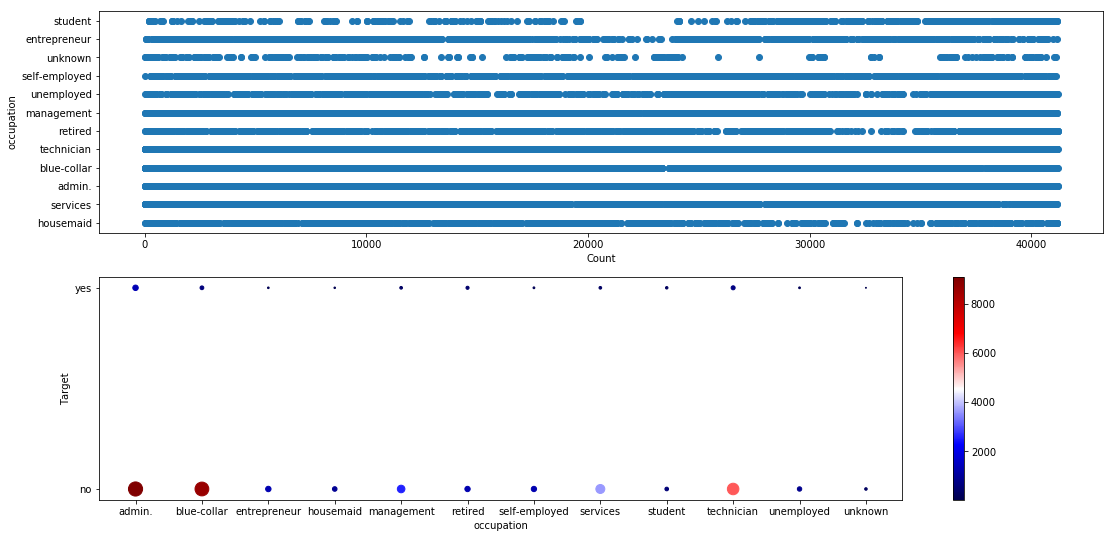

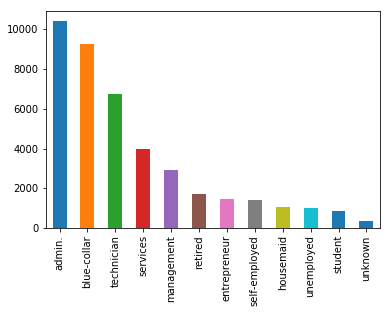

In [23]:
quick_plot_categorical(2, raw, 'occupation')

### Marital status

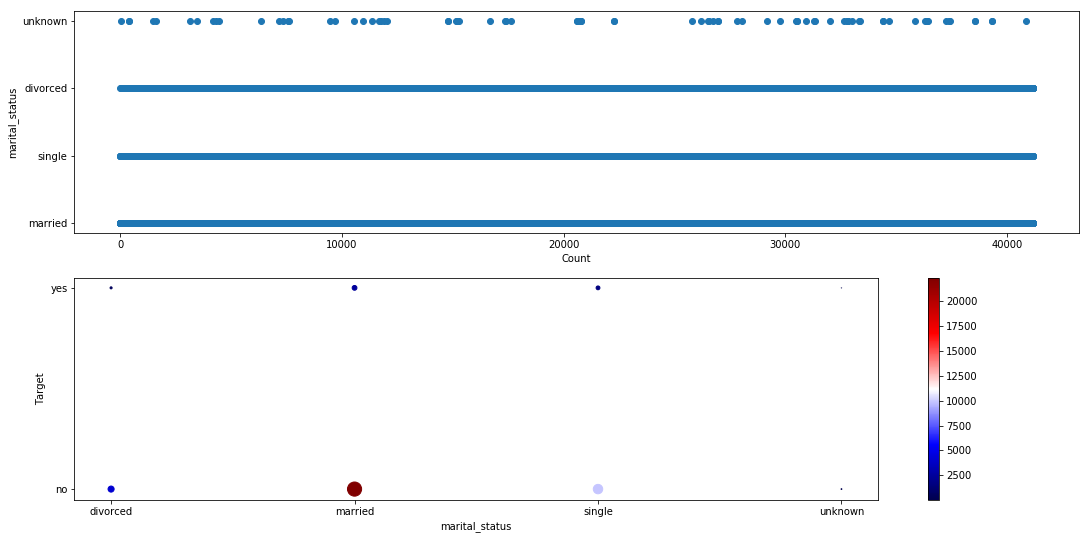

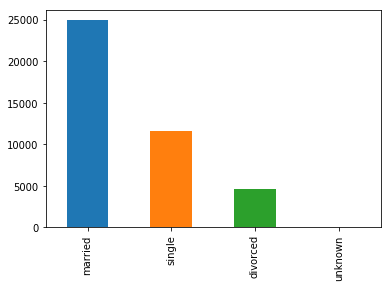

In [24]:
quick_plot_categorical(3, raw, 'marital_status')

### Education

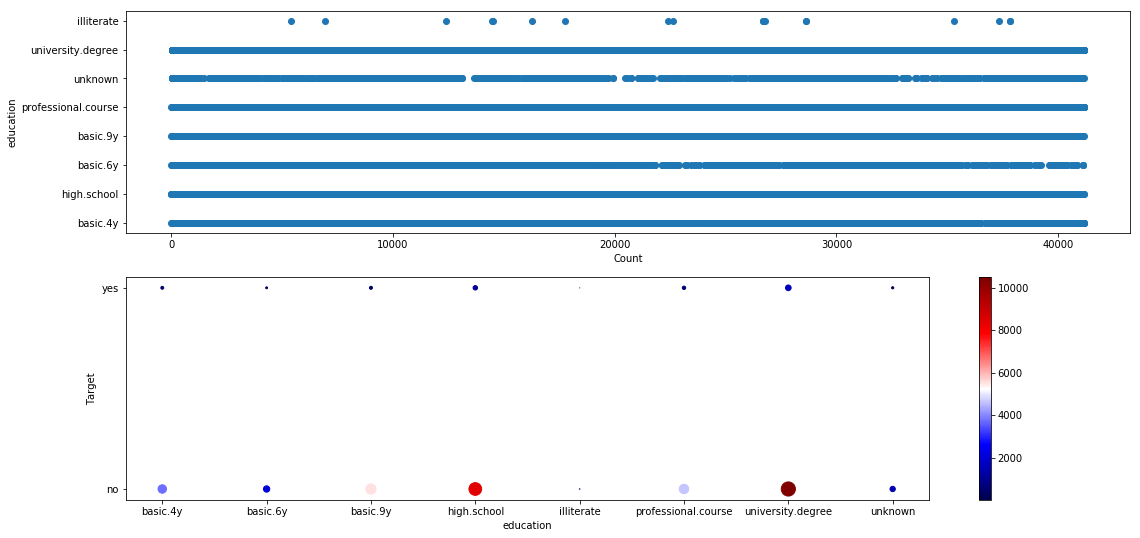

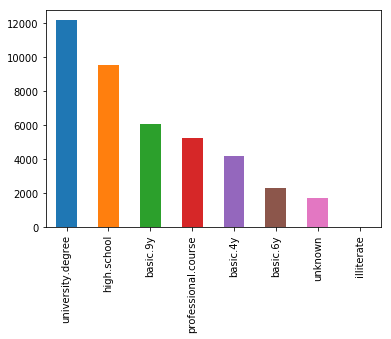

In [25]:
quick_plot_categorical(4, raw, 'education')

### Has credit

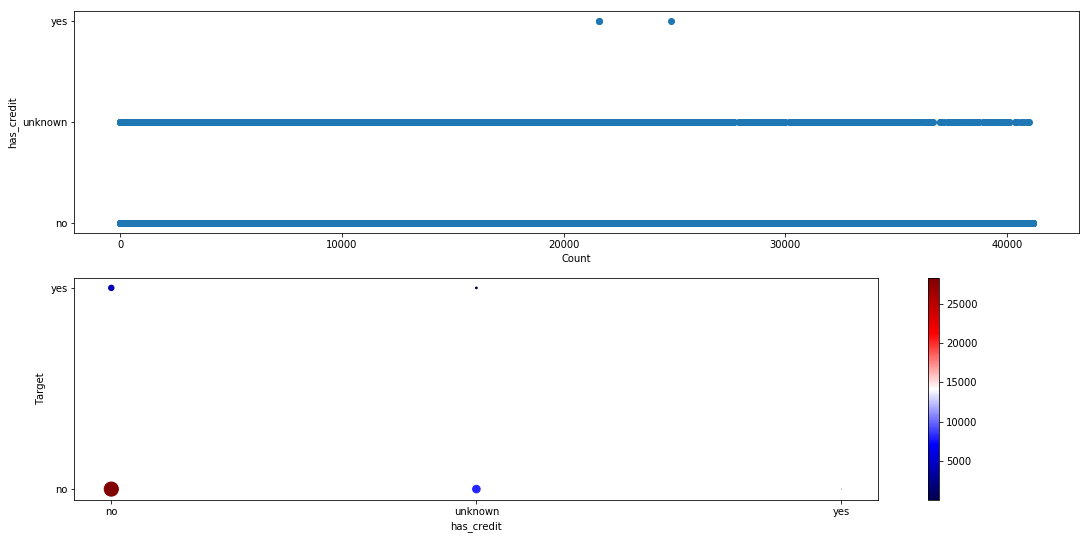

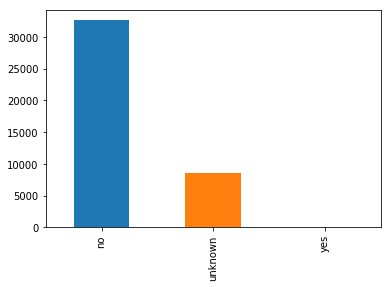

In [26]:
quick_plot_categorical(5, raw, 'has_credit')

Does not look like a good feature.

### Housing loan

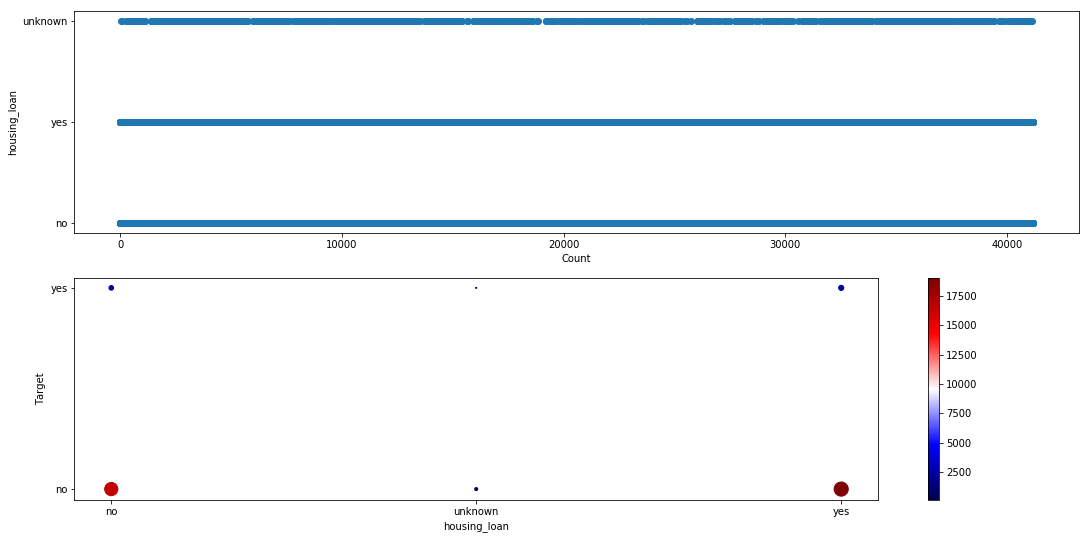

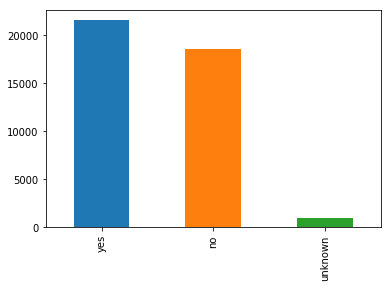

In [27]:
quick_plot_categorical(6, raw, 'housing_loan')

### Personal loan

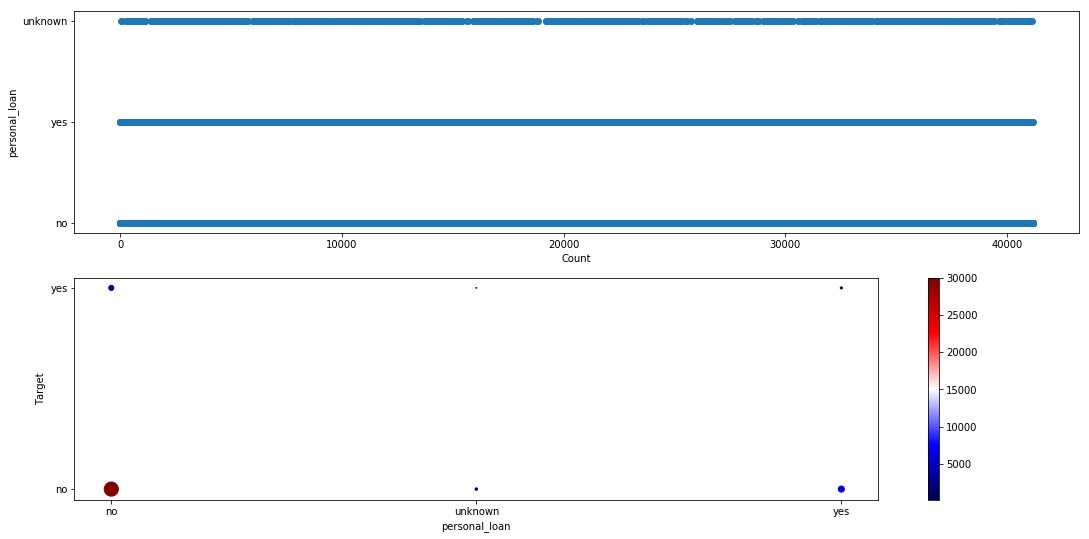

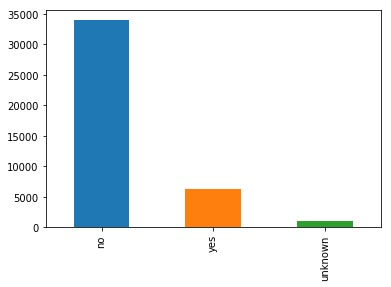

In [28]:
quick_plot_categorical(7, raw, 'personal_loan')

### Contact mode

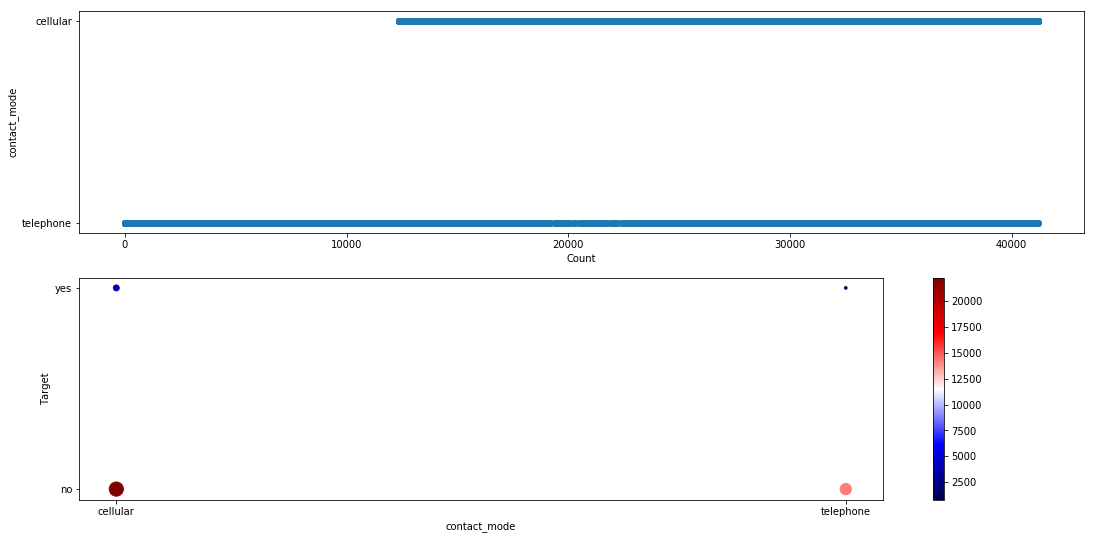

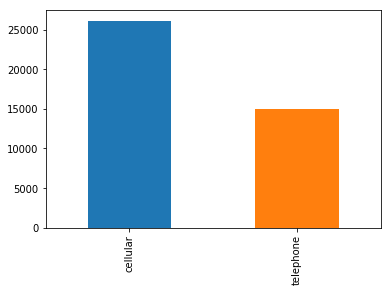

In [29]:
quick_plot_categorical(8, raw, 'contact_mode')

### Month

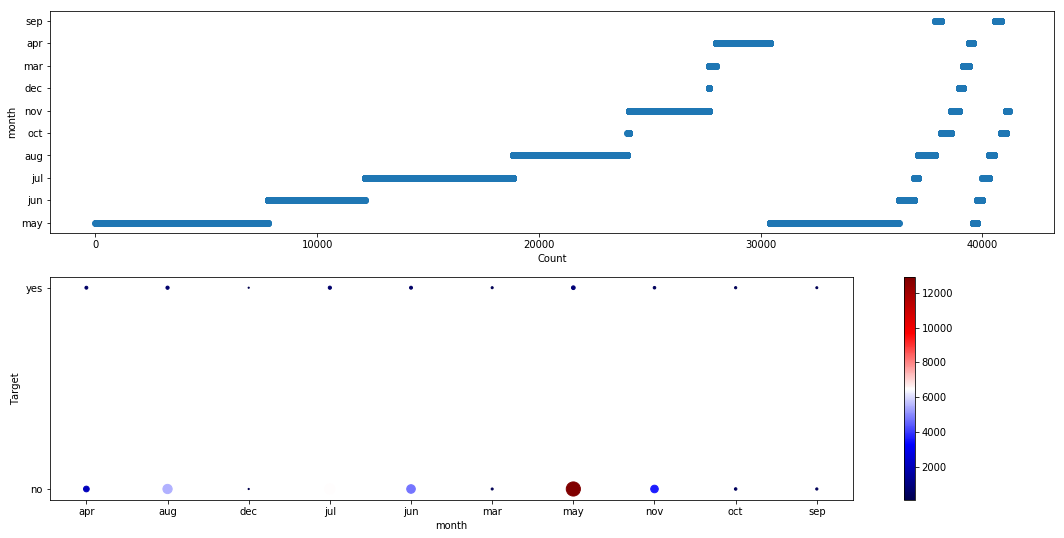

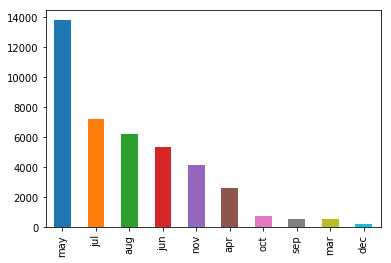

In [30]:
quick_plot_categorical(9, raw, 'month')

Date seems sorted by time. Perhaps a good idea to add a (relative) year feature?

### Week day

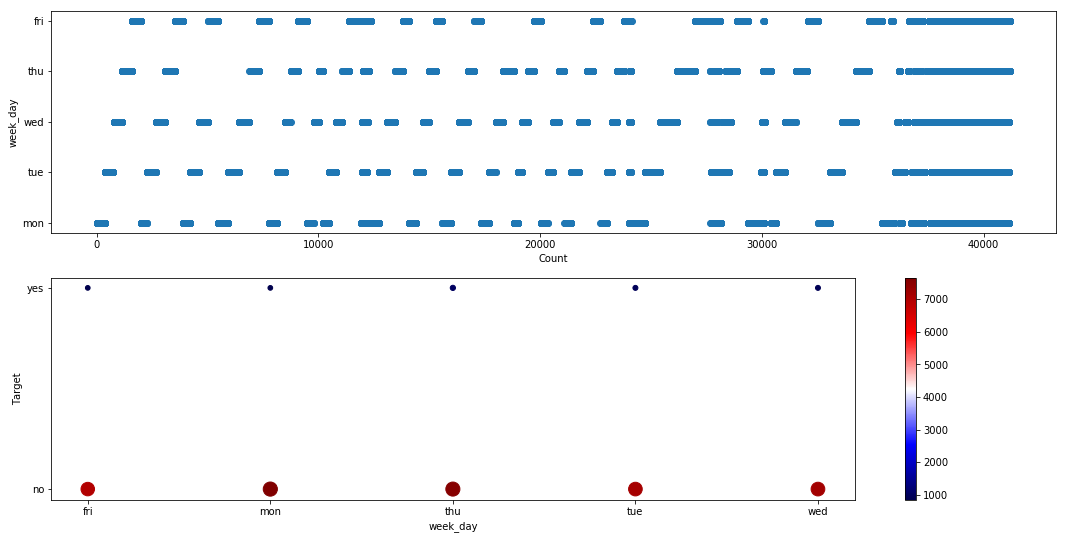

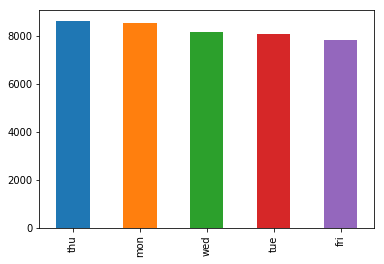

In [31]:
quick_plot_categorical(10, raw, 'week_day')

### Contact duration

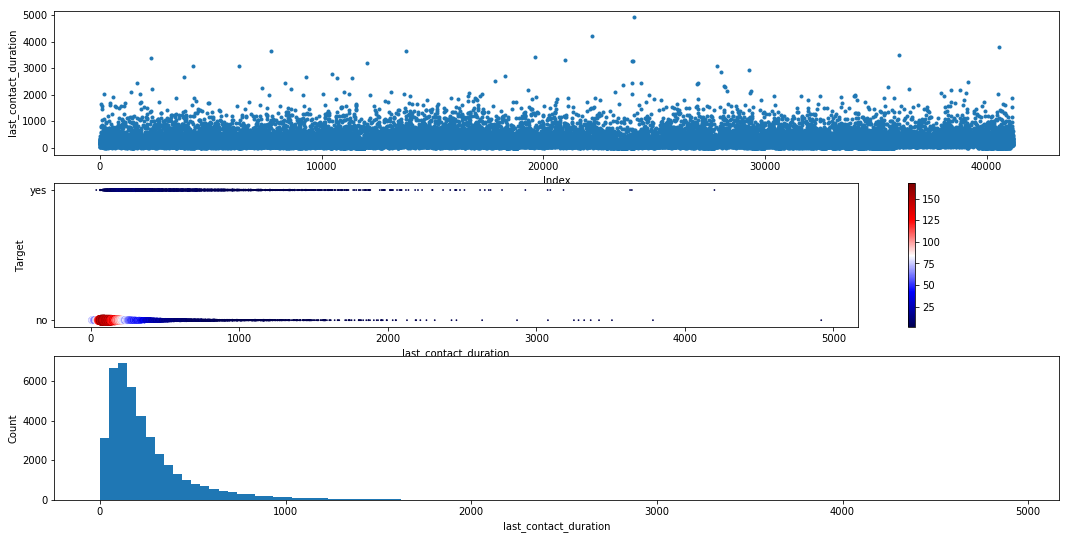

In [32]:
quick_plot_numeric(11, raw, 'last_contact_duration')

### Contact per campaign

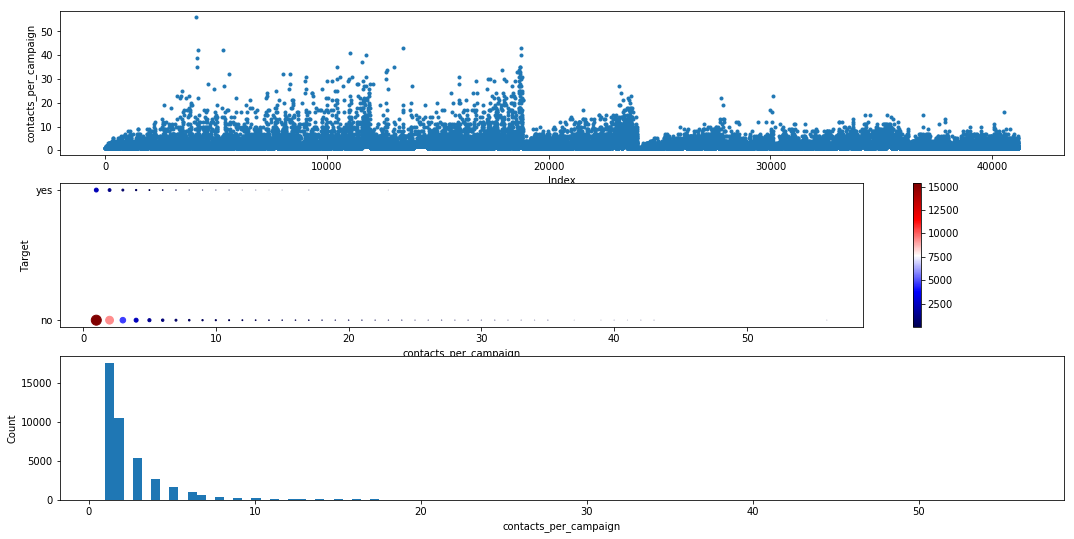

In [33]:
quick_plot_numeric(12, raw, 'contacts_per_campaign')

Perhaps a few outliers here?

### N last days

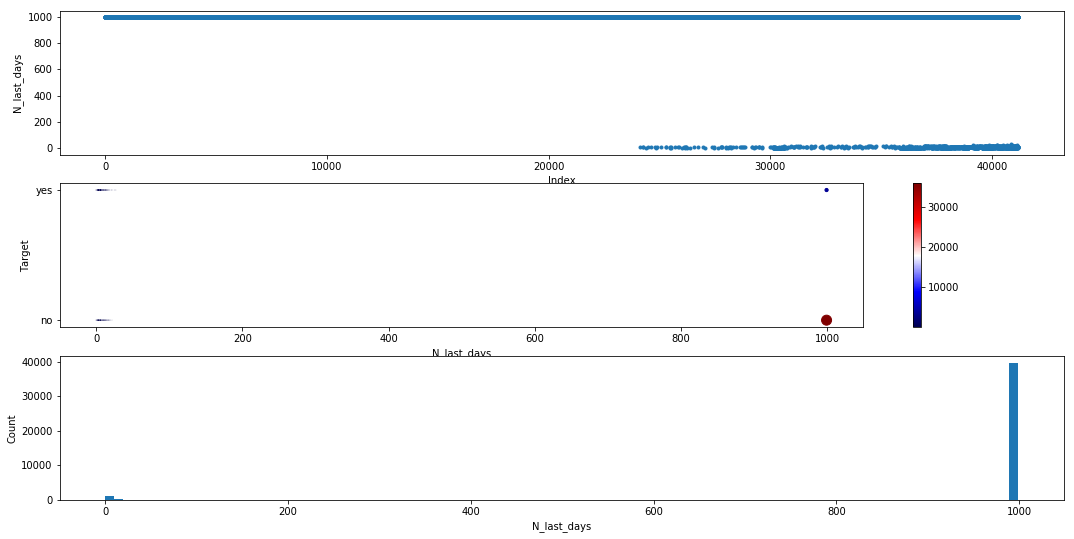

In [34]:
quick_plot_numeric(12, raw, 'N_last_days')

Should be plotted without the "never contacted" records coded with 999.

### Nb previous contact

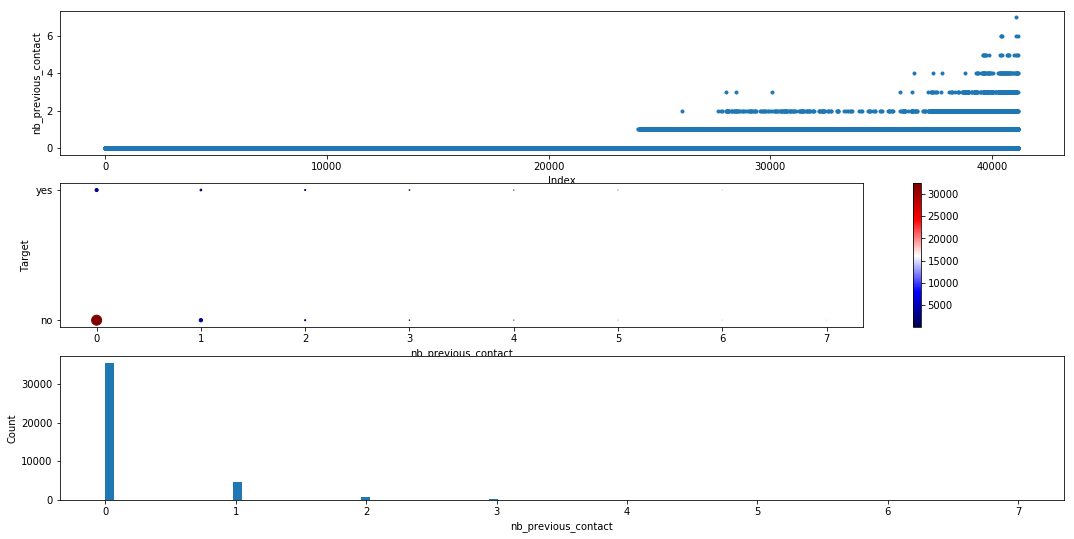

In [35]:
quick_plot_numeric(14, raw, 'nb_previous_contact')

As time goes by there are more and more previous contacts on average.

### Previous outcome

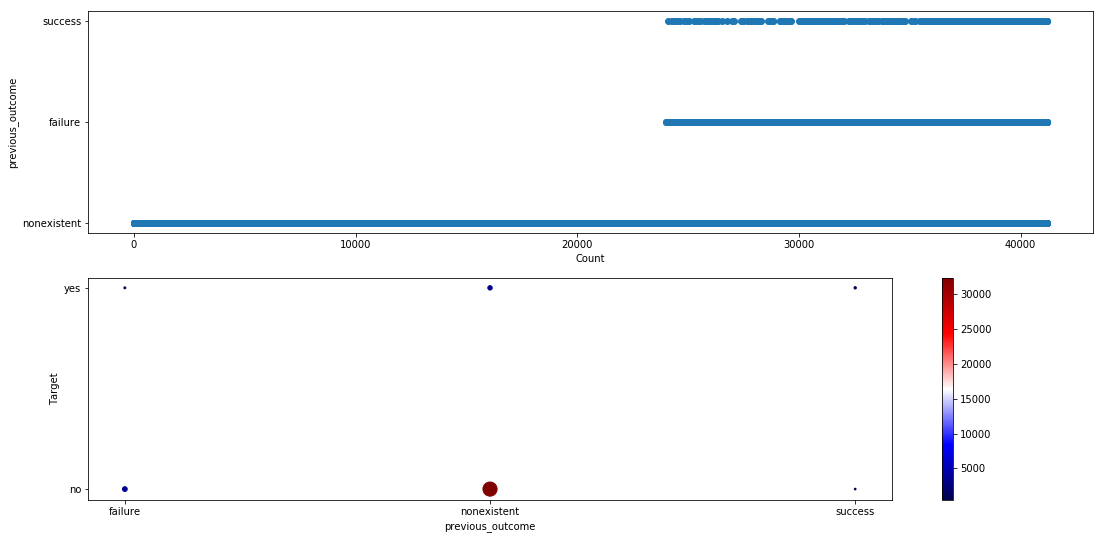

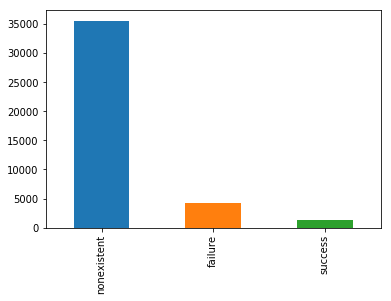

In [36]:
quick_plot_categorical(15, raw, 'previous_outcome')

### Emp var rate

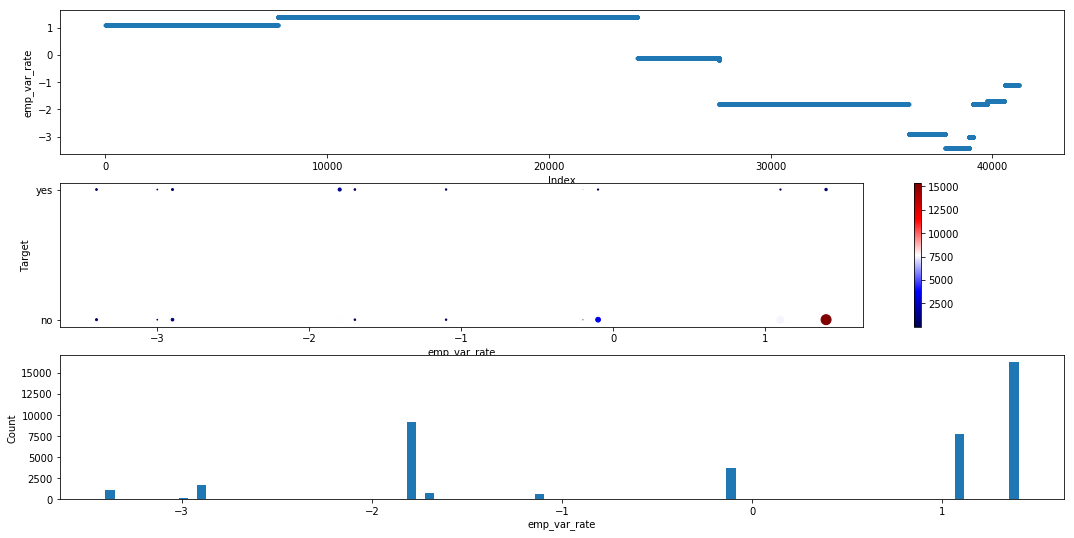

In [37]:
quick_plot_numeric(16, raw, 'emp_var_rate')

### Consumer price idx

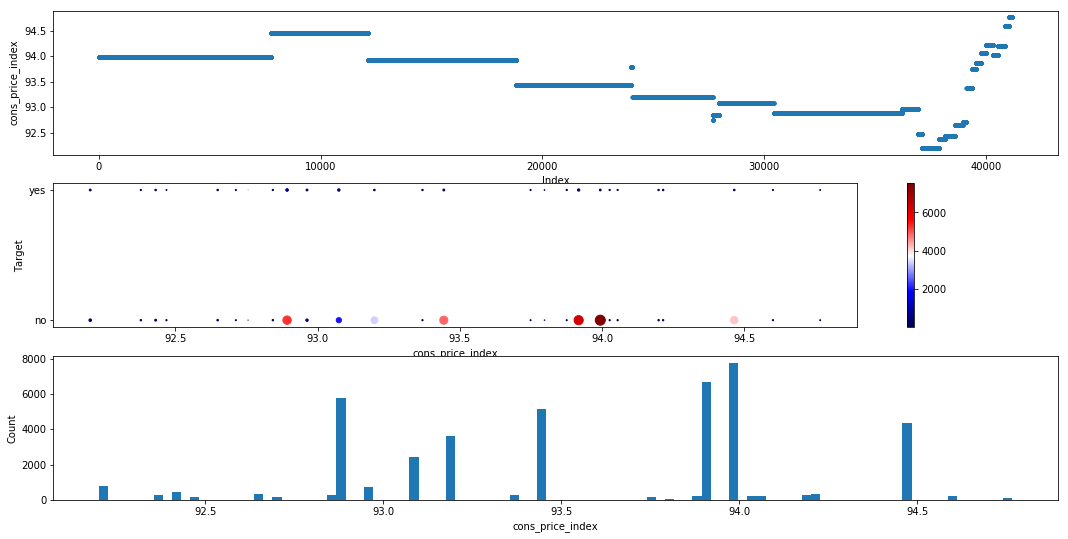

In [38]:
quick_plot_numeric(17, raw, 'cons_price_index')

### Consumer confidence idx

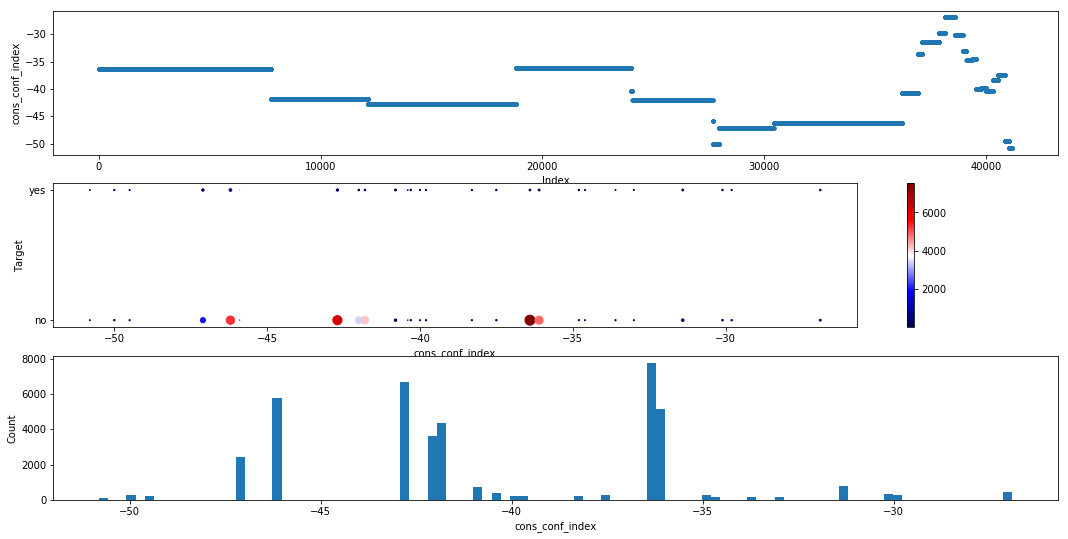

In [39]:
quick_plot_numeric(18, raw, 'cons_conf_index')

### 3 month Euribor rate

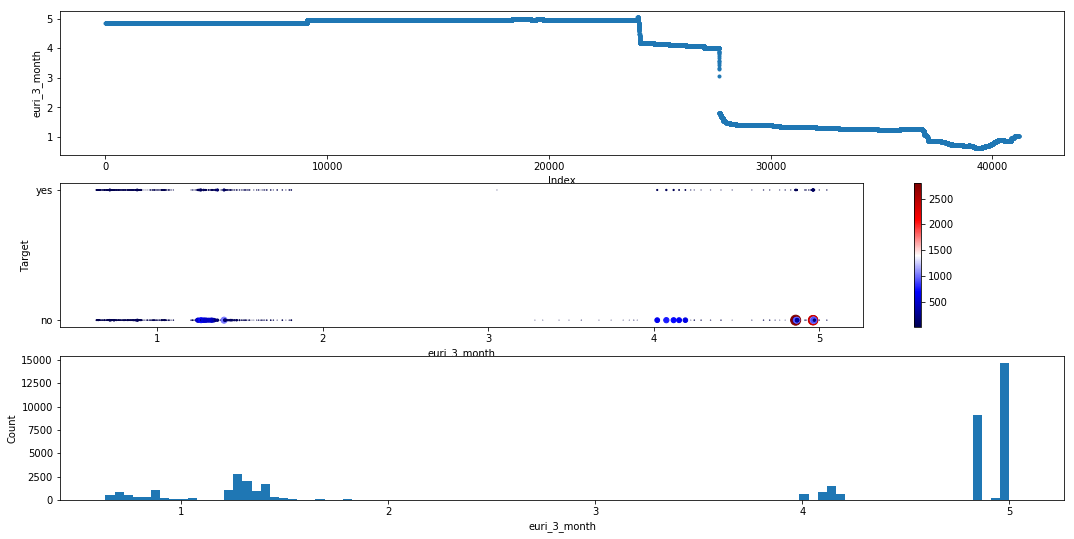

In [40]:
quick_plot_numeric(19, raw, 'euri_3_month')

### Employment rate

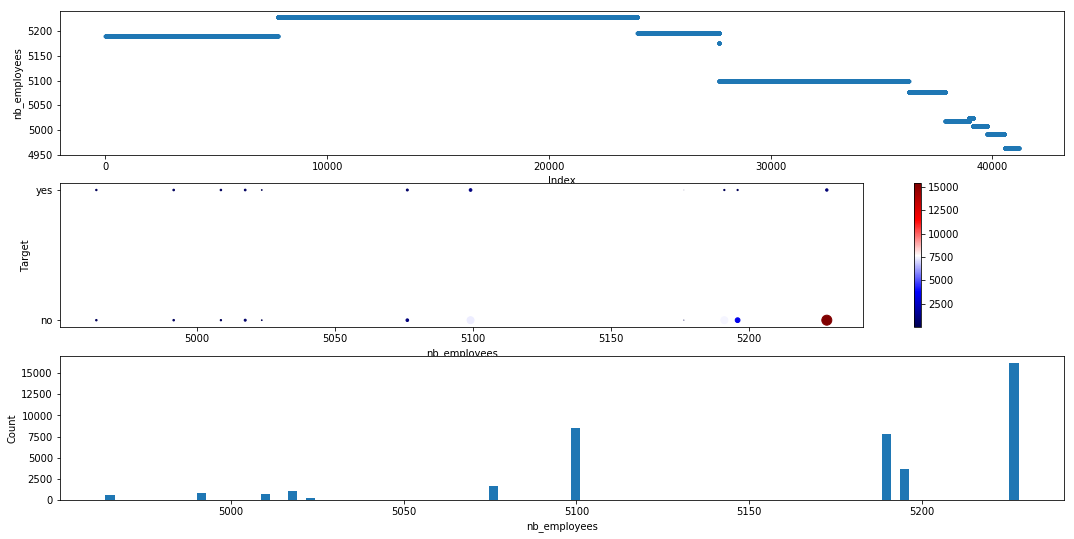

In [41]:
quick_plot_numeric(20, raw, 'nb_employees')

### Target

In [42]:
#quick_plot_categorical(21, raw, 'target')

## Quick plotting of relations

In [43]:
#pd.scatter_matrix(raw)

# Feature engineering

In [44]:
raw['age_binned'] = raw.age // 10

raw['N_last_days_valid'] = pd.Series(raw.N_last_days != 999, index=raw.index, dtype=np.float32)

educations_ordered = {'illiterate':-1, 'unknown':0, 'basic.4y':1, 'basic.6y':2, 'basic.9y':3, 
    'high.school':4, 'professional.course':5, 'university.degree':6}
raw['education_ordinal_value'] = raw.education.map(educations_ordered)

yes_no_unknown_ordered = {'no':-1, 'unknown':0, 'yes':1}
raw['has_credit_ordinal_value'] = raw.has_credit.map(yes_no_unknown_ordered)
raw['housing_loan_ordinal_value'] = raw.housing_loan.map(yes_no_unknown_ordered)
raw['personal_loan_ordinal_value'] = raw.personal_loan.map(yes_no_unknown_ordered)

months_ordered = {'may':5, 'jun':6, 'jul':7, 'aug':8, 'oct':10, 'nov':11, 'dec':12, 'mar':3, 'apr':4, 'sep':9}
raw['month_ordinal_value'] = raw.month.map(months_ordered)

weekday_ordered = {'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5}
raw['week_day_ordinal_value'] = raw.week_day.map(weekday_ordered)

previous_outcome_ordered = {'nonexistent':0, 'failure':-1, 'success':1}
raw['previous_outcome_ordinal_value'] = raw.previous_outcome.map(previous_outcome_ordered)

raw['last_contact_duration_clipped'] = raw.last_contact_duration.clip(0,2000)
raw['contacts_per_campaign_clipped'] = raw.contacts_per_campaign.clip(0,20)

raw[['education', 'education_ordinal_value', 'has_credit', 'has_credit_ordinal_value',
     'housing_loan', 'housing_loan_ordinal_value', 'personal_loan', 'personal_loan_ordinal_value',
    'month', 'month_ordinal_value', 'week_day', 'week_day_ordinal_value', 'previous_outcome', 'previous_outcome_ordinal_value',
    'last_contact_duration', 'last_contact_duration_clipped', 'contacts_per_campaign', 'contacts_per_campaign_clipped']].head()

,education,education_ordinal_value,has_credit,has_credit_ordinal_value,housing_loan,housing_loan_ordinal_value,personal_loan,personal_loan_ordinal_value,month,month_ordinal_value,week_day,week_day_ordinal_value,previous_outcome,previous_outcome_ordinal_value,last_contact_duration,last_contact_duration_clipped,contacts_per_campaign,contacts_per_campaign_clipped
0,basic.4y,1,no,-1,no,-1,no,-1,may,5,mon,1,nonexistent,0,261,261,1,1
1,high.school,4,unknown,0,no,-1,no,-1,may,5,mon,1,nonexistent,0,149,149,1,1
2,high.school,4,no,-1,yes,1,no,-1,may,5,mon,1,nonexistent,0,226,226,1,1
3,basic.6y,2,no,-1,no,-1,no,-1,may,5,mon,1,nonexistent,0,151,151,1,1
4,high.school,4,no,-1,no,-1,yes,1,may,5,mon,1,nonexistent,0,307,307,1,1


In [45]:
categorical_features = ['occupation', 'marital_status', 'education', 'has_credit', 'housing_loan', 'personal_loan', 'contact_mode', 'month', 'week_day', 'previous_outcome']
numeric_features = ['age', 'last_contact_duration', 'contacts_per_campaign', 'N_last_days', 'nb_previous_contact', 'emp_var_rate', 'cons_price_index', 'cons_conf_index', 'euri_3_month', 'nb_employees']

In [46]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn_pandas import DataFrameMapper, gen_features

def create_mapper():
    categorial_maps = gen_features(
        columns=[[feature] for feature in categorical_features],
        classes=[{'class': OneHotEncoder, 'dtype': np.float32, 'sparse':False, 'handle_unknown':'ignore'}])
    numeric_maps = gen_features(
        columns=[[feature] for feature in numeric_features],
        classes=[StandardScaler])

    return DataFrameMapper(categorial_maps + numeric_maps, default=None, df_out=True)

In [47]:
mapper = create_mapper()
mapped_data = mapper.fit_transform(raw.loc[:, raw.columns != 'target'])
mapped_data.head()

/home/mortennp/anaconda3/envs/AdvML3_6/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/mortennp/anaconda3/envs/AdvML3_6/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/mortennp/anaconda3/envs/AdvML3_6/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/mortennp/anaconda3/envs/AdvML3_6/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/mortennp/anaconda3/envs/AdvML3_6/lib/p

,occupation_x0_admin.,occupation_x0_blue-collar,occupation_x0_entrepreneur,occupation_x0_housemaid,occupation_x0_management,occupation_x0_retired,occupation_x0_self-employed,occupation_x0_services,occupation_x0_student,occupation_x0_technician,occupation_x0_unemployed,occupation_x0_unknown,marital_status_x0_divorced,marital_status_x0_married,marital_status_x0_single,marital_status_x0_unknown,education_x0_basic.4y,education_x0_basic.6y,education_x0_basic.9y,education_x0_high.school,education_x0_illiterate,education_x0_professional.course,education_x0_university.degree,education_x0_unknown,has_credit_x0_no,has_credit_x0_unknown,has_credit_x0_yes,housing_loan_x0_no,housing_loan_x0_unknown,housing_loan_x0_yes,personal_loan_x0_no,personal_loan_x0_unknown,personal_loan_x0_yes,contact_mode_x0_cellular,contact_mode_x0_telephone,month_x0_apr,month_x0_aug,month_x0_dec,month_x0_jul,month_x0_jun,month_x0_mar,month_x0_may,month_x0_nov,month_x0_oct,month_x0_sep,week_day_x0_fri,week_day_x0_mon,week_day_x0_thu,week_day_x0_tue,week_day_x0_wed,previous_outcome_x0_failure,previous_outcome_x0_nonexistent,previous_outcome_x0_success,age,last_contact_duration,contacts_per_campaign,N_last_days,nb_previous_contact,emp_var_rate,cons_price_index,cons_conf_index,euri_3_month,nb_employees,age_binned,N_last_days_valid,education_ordinal_value,has_credit_ordinal_value,housing_loan_ordinal_value,personal_loan_ordinal_value,month_ordinal_value,week_day_ordinal_value,previous_outcome_ordinal_value,last_contact_duration_clipped,contacts_per_campaign_clipped
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.533034,0.010471,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,5.0,0.0,1.0,-1.0,-1.0,-1.0,5.0,1.0,0.0,261.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.628993,-0.421501,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,5.0,0.0,4.0,0.0,-1.0,-1.0,5.0,1.0,0.0,149.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.290186,-0.124520,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,3.0,0.0,4.0,-1.0,1.0,-1.0,5.0,1.0,0.0,226.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.002309,-0.413787,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,4.0,0.0,2.0,-1.0,-1.0,-1.0,5.0,1.0,0.0,151.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.533034,0.187888,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,5.0,0.0,4.0,-1.0,-1.0,1.0,5.0,1.0,0.0,307.0,1.0


# Dataset split

In [48]:
from sklearn.model_selection import train_test_split

X = mapped_data.values
y = np.array(raw.target == 'yes')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, shuffle=True, stratify=y, random_state=SEED)

In [49]:
save_data(CTX + 'X_train', X_train)
save_data(CTX + 'X_test', X_test)
save_data(CTX + 'y_train', y_train)
save_data(CTX + 'y_test', y_test)

Saving ./cache/Bank_Marketing_Case_v3_X_train.h5
Saving ./cache/Bank_Marketing_Case_v3_X_test.h5
Saving ./cache/Bank_Marketing_Case_v3_y_train.h5
Saving ./cache/Bank_Marketing_Case_v3_y_test.h5


In [50]:
#X_train = load_data(CTX + 'X_train', np.empty(0))
#X_test = load_data(CTX + 'X_test', np.empty(0))
#y_train = load_data(CTX + 'y_train', np.empty(0))
#y_test = load_data(CTX + 'y_test', np.empty(0))

# Model fitting

In [51]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

def grid_search(est, param_grid, filename):
    search_est = GridSearchCV(
        est,
        param_grid,
        scoring='accuracy',
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED),
        refit=True,
        return_train_score=True,
        n_jobs=-1,
        verbose=True)
    
    search_est.fit(X_train, y_train)
    
    print(search_est.cv_results_)
    print(search_est.best_score_)
    print(search_est.best_params_)
    
    save_model(filename, search_est.best_estimator_)    
    
    return search_est.best_estimator_    

## Baseline

In [52]:
y_pred = np.zeros(y_test.shape)
score('Baseline', y_test, y_pred)

Baseline
Accuracy is 0.887351
ROC AUC is 0.500000
Precision is 0.000000
Recall is 0.000000


/home/mortennp/anaconda3/envs/AdvML3_6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## Logistic regression

In [53]:
from sklearn.linear_model import LogisticRegression

logreg_search_est = grid_search(
    LogisticRegression(solver='liblinear', penalty='l1', n_jobs=-1, verbose=False, random_state=SEED),
    {'C':[0.1, 0.3, 1.0, 3.0, 10.0]}, 
    CTX + 'logreg_search_est')

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.1min finished


{'mean_fit_time': array([5.55179326, 3.9258666 , 5.13507803, 5.32540894, 2.9656028 ]), 'std_fit_time': array([0.40631545, 0.5472235 , 2.52733208, 2.3115793 , 0.60695544]), 'mean_score_time': array([0.00207901, 0.00206391, 0.00207496, 0.00206081, 0.00208728]), 'std_score_time': array([2.20954560e-05, 4.13106010e-06, 4.24710874e-05, 1.69644308e-05,
       2.39847458e-05]), 'param_C': masked_array(data=[0.1, 0.3, 1.0, 3.0, 10.0],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.1}, {'C': 0.3}, {'C': 1.0}, {'C': 3.0}, {'C': 10.0}], 'split0_test_score': array([0.90968682, 0.91114348, 0.91146718, 0.91179089, 0.91162904]), 'split1_test_score': array([0.90757527, 0.90878925, 0.90887018, 0.90862739, 0.90854646]), 'split2_test_score': array([0.91364519, 0.91404985, 0.91469731, 0.91453545, 0.91445452]), 'mean_test_score': array([0.91030241, 0.91132752, 0.91167822, 0.91165124, 0.91154334]), 'std_test_score': array([0.002515

In [54]:
y_pred_probs = logreg_search_est.predict(X_test)
y_pred = [round(value) for value in y_pred_probs]
score('Logistic Regression', y_test, y_pred)

Logistic Regression
Accuracy is 0.908958
ROC AUC is 0.700333
Precision is 0.643087
Recall is 0.431034


In [55]:
logreg_feature_importance = abs(logreg_search_est.coef_[0])
logreg_feature_importance = 100.0 * (logreg_feature_importance / logreg_feature_importance.max())

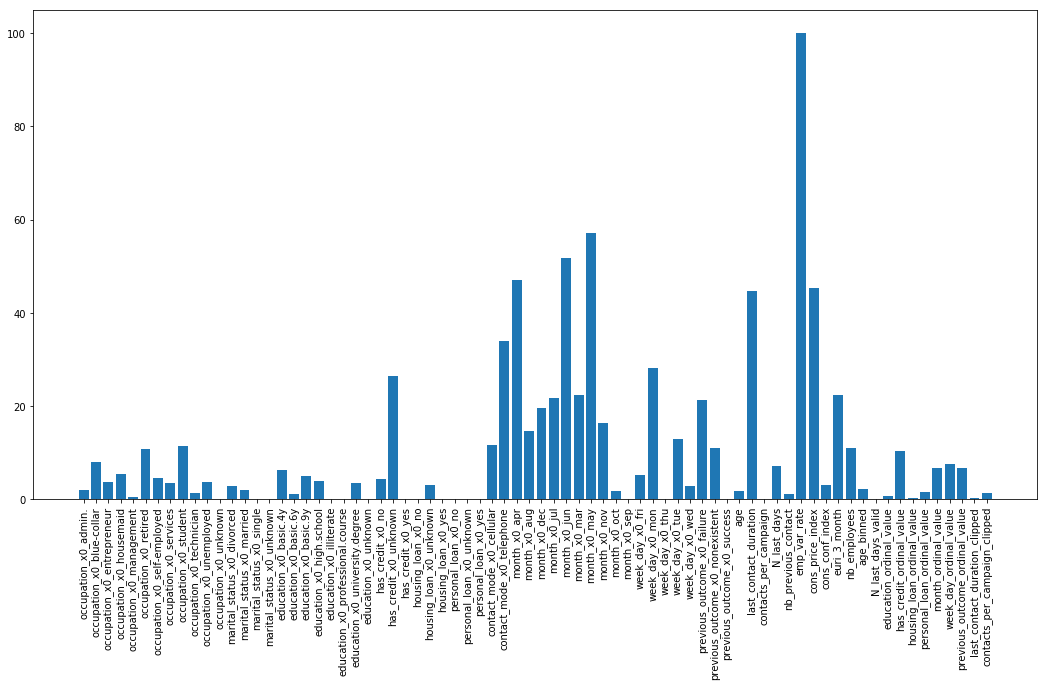

In [56]:
plt.figure(101, figsize=(18,9))
plt.bar(mapper.transformed_names_, logreg_feature_importance)
plt.xticks(rotation=90)
plt.show()

## XGBoost

In [57]:
xgb_search_est = grid_search(
    xgb.XGBClassifier(objective='binary:logistic', n_jobs=-1, silent=False, random_state=SEED), #**{'tree_method':'gpu_hist'}) 
    {'n_estimators':[50, 100, 150], 'learning_rate':[0.01, 0.03, 0.1], 'max_depth':[5,6,7]},
    CTX + 'xgb_search_est')

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[21:50:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[21:50:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:49] /work

[21:50:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:50:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:50:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:50:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:51] /work

[21:50:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[21:50:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:52] /work

[21:50:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:50:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:50:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:50:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:50:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:50:54] /work

[21:50:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:55] /work

[21:50:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:50:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:50:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[21:50:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[21:50:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:50:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[21:50:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[21:50:56] /work

[21:50:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:50:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:50:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:50:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:50:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[21:50:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:58] /work

[21:50:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:50:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:50:59] /work

[21:51:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:51:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:51:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:51:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:51:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[21:51:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[21:51:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[21:51:00] /work

[21:51:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:02] /work

[21:51:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:03] /work

[21:51:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:51:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:05] /work

[21:51:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:51:06] /work

[21:51:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:51:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:51:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:51:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:51:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:51:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:51:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:51:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:51:0

[21:51:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:51:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:51:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:51:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:51:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:51:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:51:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:51:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:51:1

[21:51:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:51:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:51:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:51:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:51:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:51:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:51:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:51:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:51:1

[21:51:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:51:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:51:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:51:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:51:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:51:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:51:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:51:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:51:1

[21:51:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[21:51:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:51:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:51:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:51:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:51:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:51:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:51:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:51:1

[21:51:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:51:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:51:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[21:51:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:51:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:51:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:51:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[21:51:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:51:1

[21:51:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:51:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:51:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:51:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:51:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:51:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:51:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:51:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:51:2

[21:51:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[21:51:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:51:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:51:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:51:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:51:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:51:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:51:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[21:51:2

[21:51:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:51:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:51:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:51:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:51:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:51:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:51:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:51:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:51:2

[21:51:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:51:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:51:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:51:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:51:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:51:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:51:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:51:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:51:3

[21:51:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[21:51:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[21:51:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:51:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[21:51:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[21:51:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[21:51:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[21:51:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:51:3

[21:51:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[21:51:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:51:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:51:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:51:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:51:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:51:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:51:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:51:3

[21:51:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[21:51:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:51:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:51:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:51:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:51:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:51:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:51:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:51:3

[21:51:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[21:51:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[21:51:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=7
[21:51:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=7
[21:51:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[21:51:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[21:51:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=7
[21:51:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[21:51:4

[21:51:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[21:51:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[21:51:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[21:51:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=7
[21:51:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[21:51:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=7
[21:51:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=7
[21:51:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=7
[21:51:4

[21:51:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[21:51:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=7
[21:51:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[21:51:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=7
[21:51:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[21:51:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[21:51:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[21:51:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[21:51:4

[21:51:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[21:51:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=7
[21:51:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[21:51:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[21:51:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=7
[21:51:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=7
[21:51:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[21:51:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[21:51:4

[21:51:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[21:51:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[21:51:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[21:51:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[21:51:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[21:51:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[21:51:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[21:51:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[21:51:5

[21:51:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[21:51:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[21:51:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=7
[21:51:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[21:51:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=7
[21:51:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=7
[21:51:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=7
[21:51:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[21:51:5

[21:51:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=7
[21:51:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=7
[21:51:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[21:51:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[21:51:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[21:51:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[21:51:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=7
[21:51:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[21:51:5

[21:51:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=7
[21:51:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=7
[21:51:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=7
[21:51:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=7
[21:51:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=7
[21:51:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[21:51:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[21:51:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=7
[21:51:5

[21:51:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[21:51:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[21:51:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=7
[21:51:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[21:51:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[21:51:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[21:51:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[21:51:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=7
[21:51:5

[21:52:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[21:52:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[21:52:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[21:52:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[21:52:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=7
[21:52:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[21:52:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[21:52:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[21:52:0

[21:52:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=7
[21:52:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[21:52:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=7
[21:52:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=7
[21:52:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=7
[21:52:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=7
[21:52:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=7
[21:52:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=7
[21:52:0

[21:52:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[21:52:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[21:52:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[21:52:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=7
[21:52:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[21:52:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[21:52:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[21:52:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=7
[21:52:0

[21:52:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:07] /work

[21:52:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:09] /work

[21:52:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:10] /work

[21:52:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:52:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:52:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:52:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:52:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:52:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:52:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:52:12] /work

[21:52:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:13] /work

[21:52:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[21:52:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:52:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[21:52:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[21:52:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:52:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:52:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:52:15] /work

[21:52:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[21:52:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[21:52:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[21:52:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[21:52:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[21:52:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[21:52:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[21:52:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[21:52:16] /work

[21:52:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:18] /work

[21:52:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[21:52:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[21:52:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[21:52:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[21:52:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[21:52:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[21:52:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[21:52:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[21:52:19] /work

[21:52:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:21] /work

[21:52:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:52:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[21:52:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[21:52:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[21:52:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[21:52:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[21:52:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[21:52:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[21:52:22] /work

[21:52:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:52:24] /work

[21:52:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[21:52:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[21:52:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[21:52:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[21:52:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[21:52:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[21:52:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[21:52:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[21:52:25] /work

[21:52:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:52:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:52:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[21:52:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:52:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:52:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:52:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[21:52:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:52:2

[21:52:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:52:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:52:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:52:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:52:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[21:52:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:52:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[21:52:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[21:52:2

[21:52:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:52:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[21:52:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[21:52:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[21:52:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[21:52:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:52:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[21:52:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[21:52:3

[21:52:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[21:52:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[21:52:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[21:52:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[21:52:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[21:52:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[21:52:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:52:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:52:32] /

[21:52:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[21:52:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[21:52:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[21:52:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[21:52:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[21:52:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[21:52:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[21:52:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[21:52:3

[21:52:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:52:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:52:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:52:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:52:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[21:52:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:52:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:52:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:52:3

[21:52:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:52:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:52:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:52:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:52:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:52:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:52:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:52:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:52:3

[21:52:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[21:52:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[21:52:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[21:52:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[21:52:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:52:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[21:52:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[21:52:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[21:52:39

[21:52:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[21:52:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[21:52:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:52:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:52:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:52:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:52:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:52:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:52:41]

[21:52:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:52:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:52:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[21:52:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[21:52:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[21:52:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[21:52:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[21:52:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[21:52:4

[21:52:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[21:52:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[21:52:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[21:52:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[21:52:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[21:52:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[21:52:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[21:52:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[21:52:44] /work

[21:52:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:52:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:52:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:52:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:52:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:52:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:52:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[21:52:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:52:4

[21:52:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[21:52:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[21:52:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[21:52:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[21:52:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[21:52:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[21:52:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[21:52:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[21:52:48] /work

[21:52:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[21:52:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[21:52:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=7
[21:52:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[21:52:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[21:52:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=7
[21:52:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[21:52:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[21:52:5

[21:52:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=7
[21:52:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[21:52:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=7
[21:52:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[21:52:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[21:52:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=7
[21:52:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[21:52:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=7
[21:52:5

[21:52:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[21:52:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=7
[21:52:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[21:52:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=7
[21:52:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[21:52:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[21:52:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=7
[21:52:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=7
[21:52:5

[21:52:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=7
[21:52:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=7
[21:52:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[21:52:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=7
[21:52:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=7
[21:52:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=7
[21:52:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=7
[21:52:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[21:52:5

[21:52:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=7
[21:52:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=7
[21:52:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=7
[21:52:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[21:52:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=7
[21:52:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=7
[21:52:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[21:52:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[21:52:5

[21:52:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[21:52:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=7
[21:52:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[21:52:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=7
[21:52:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[21:52:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[21:53:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[21:53:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=7
[21:53:0

[21:53:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=7
[21:53:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=7
[21:53:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=7
[21:53:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=7
[21:53:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=7
[21:53:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=7
[21:53:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=7
[21:53:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=7
[21:53:0

[21:53:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=7
[21:53:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=7
[21:53:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[21:53:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=7
[21:53:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=7
[21:53:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=7
[21:53:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=7
[21:53:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=7
[21:53:0

[21:53:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[21:53:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=7
[21:53:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=7
[21:53:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[21:53:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=7
[21:53:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[21:53:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=7
[21:53:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=7
[21:53:0

[21:53:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=7
[21:53:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=7
[21:53:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[21:53:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=7
[21:53:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=7
[21:53:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=7
[21:53:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=7
[21:53:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[21:53:0

[21:53:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[21:53:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=7
[21:53:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=7
[21:53:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[21:53:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=7
[21:53:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[21:53:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=7
[21:53:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[21:53:1

[21:53:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[21:53:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=7
[21:53:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=7
[21:53:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=7
[21:53:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[21:53:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=7
[21:53:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=7
[21:53:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=7
[21:53:1

[21:53:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:53:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:53:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:53:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:53:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:53:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:53:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:53:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:53:14] /work

[21:53:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:53:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:53:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:53:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[21:53:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[21:53:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:53:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:53:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[21:53:15] /work

[21:53:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[21:53:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[21:53:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[21:53:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[21:53:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[21:53:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[21:53:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[21:53:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[21:53:16] /work

[21:53:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[21:53:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[21:53:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[21:53:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[21:53:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[21:53:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[21:53:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[21:53:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[21:53:18] /work

[21:53:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:53:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[21:53:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[21:53:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[21:53:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[21:53:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:53:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[21:53:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[21:53:19] /work

[21:53:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[21:53:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[21:53:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[21:53:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[21:53:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[21:53:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:53:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[21:53:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:53:20] /work

[21:53:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[21:53:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[21:53:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[21:53:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[21:53:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[21:53:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:53:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[21:53:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[21:53:22] /work

[21:53:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[21:53:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[21:53:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[21:53:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[21:53:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[21:53:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[21:53:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[21:53:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[21:53:23] /work

[21:53:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[21:53:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[21:53:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[21:53:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[21:53:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[21:53:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[21:53:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[21:53:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[21:53:25] /work

[21:53:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[21:53:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[21:53:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[21:53:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[21:53:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[21:53:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[21:53:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[21:53:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[21:53:27] /work

[21:53:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[21:53:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[21:53:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[21:53:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[21:53:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[21:53:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[21:53:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[21:53:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[21:53:28] /work

[21:53:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[21:53:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[21:53:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[21:53:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[21:53:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[21:53:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[21:53:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[21:53:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[21:53:30] /work

[21:53:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[21:53:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[21:53:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[21:53:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[21:53:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[21:53:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[21:53:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[21:53:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[21:53:31] /work

[21:53:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[21:53:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[21:53:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[21:53:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[21:53:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[21:53:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[21:53:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[21:53:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[21:53:33] /work

[21:53:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:53:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:53:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:53:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:53:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:53:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:53:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:53:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:53:3

[21:53:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[21:53:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[21:53:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[21:53:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[21:53:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[21:53:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[21:53:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[21:53:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[21:53:36] /wor

[21:53:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:53:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:53:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[21:53:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:53:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:53:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:53:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:53:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:53:3

[21:53:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[21:53:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[21:53:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[21:53:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[21:53:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[21:53:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[21:53:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[21:53:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[21:53:39] /work

[21:53:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[21:53:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[21:53:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[21:53:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[21:53:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[21:53:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[21:53:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[21:53:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[21:53:41] /work

[21:53:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:53:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:53:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:53:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:53:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:53:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[21:53:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:53:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:53:4

[21:53:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[21:53:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[21:53:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[21:53:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[21:53:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[21:53:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[21:53:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[21:53:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[21:53:44] /wor

[21:53:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:53:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:53:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[21:53:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:53:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:53:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:53:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:53:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:53:4

[21:53:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[21:53:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[21:53:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[21:53:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[21:53:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[21:53:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[21:53:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[21:53:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[21:53:47] /work

[21:53:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[21:53:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[21:53:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[21:53:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[21:53:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[21:53:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[21:53:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[21:53:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[21:53:49] /work

[21:53:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[21:53:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[21:53:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[21:53:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[21:53:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[21:53:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[21:53:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[21:53:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[21:53:51] /work

[21:53:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[21:53:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[21:53:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[21:53:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[21:53:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[21:53:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[21:53:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[21:53:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[21:53:52] /wo

[21:53:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[21:53:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=7
[21:53:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[21:53:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[21:53:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=7
[21:53:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[21:53:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[21:53:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=7
[21:53:5

[21:53:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=7
[21:53:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[21:53:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=7
[21:53:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=7
[21:53:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=7
[21:53:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=7
[21:53:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=7
[21:53:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=7
[21:53:5

[21:53:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[21:53:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[21:53:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[21:53:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[21:53:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[21:53:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[21:53:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[21:53:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[21:53:58] /work

[21:54:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=7
[21:54:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[21:54:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[21:54:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[21:54:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[21:54:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=7
[21:54:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=7
[21:54:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=7
[21:54:0

[21:54:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=7
[21:54:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[21:54:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[21:54:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[21:54:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[21:54:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[21:54:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[21:54:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[21:54:02] /

[21:54:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=7
[21:54:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[21:54:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[21:54:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[21:54:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[21:54:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[21:54:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[21:54:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[21:54:04] /wo

[21:54:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=7
[21:54:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[21:54:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[21:54:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[21:54:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=7
[21:54:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[21:54:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[21:54:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[21:54:06] /

[21:54:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=7
[21:54:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[21:54:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[21:54:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[21:54:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[21:54:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[21:54:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[21:54:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=7
[21:54:08] /

[21:54:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=7
[21:54:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=7
[21:54:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=7
[21:54:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=7
[21:54:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=7
[21:54:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=7
[21:54:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=7
[21:54:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=7
[21:54:1

[21:54:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[21:54:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[21:54:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[21:54:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[21:54:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[21:54:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[21:54:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[21:54:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[21:54:12] /wo

[21:54:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=7
[21:54:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=7
[21:54:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=7
[21:54:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[21:54:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=7
[21:54:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=7
[21:54:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=7
[21:54:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=7
[21:54:1

[21:54:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[21:54:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[21:54:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=7
[21:54:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=7
[21:54:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[21:54:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[21:54:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[21:54:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[21:54:16] /w

[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  3.5min finished


[21:54:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:54:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:54:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:54:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:54:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:54:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:54:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:54:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:54:1

[21:54:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:54:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:54:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:54:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:54:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:54:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:54:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:54:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:54:2

In [58]:
y_pred_probs = xgb_search_est.predict(X_test)
y_pred = [round(value) for value in y_pred_probs]
score('XGBoost', y_test, y_pred)

XGBoost
Accuracy is 0.915756
ROC AUC is 0.751202
Precision is 0.652742
Recall is 0.538793


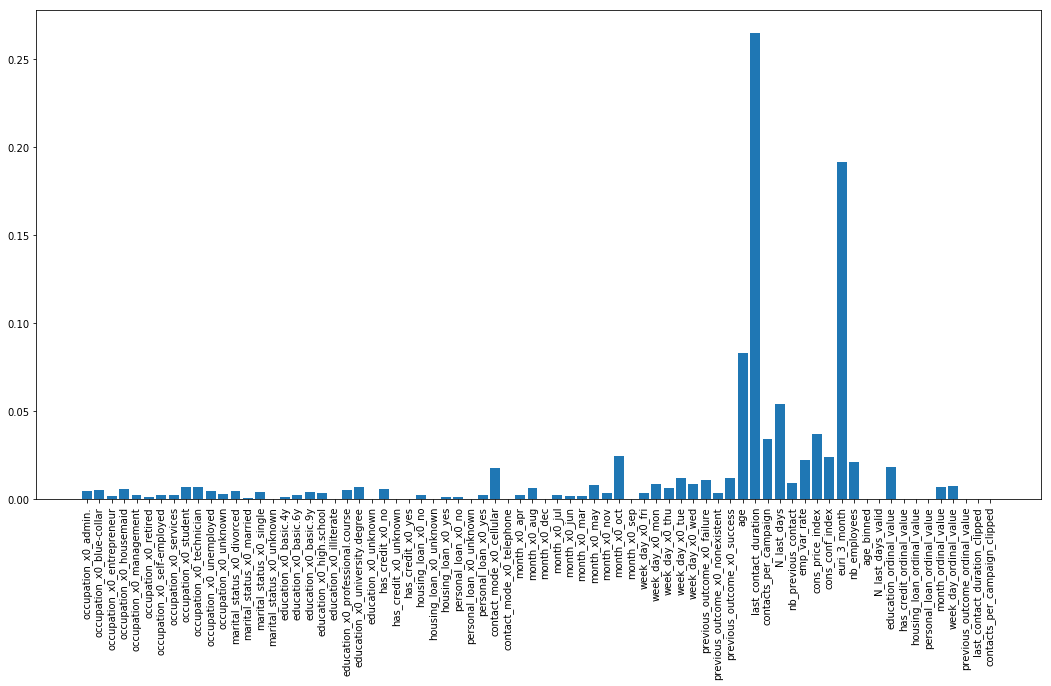

In [59]:
plt.figure(102, figsize=(18,9))
plt.bar(mapper.transformed_names_, xgb_search_est.feature_importances_)
plt.xticks(rotation=90)
plt.show()

## Neural net

In [63]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam

def create_keras_model(lr=0.001):
    model = Sequential()
    model.add(Dense(100, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        loss='binary_crossentropy',
        #optimizer=Adam(lr=lr)
        optimizer=SGD(lr=lr) #, momentum=0.0, decay=0.0, nesterov=False)
    )
    return model

In [64]:
from keras.wrappers.scikit_learn import KerasClassifier

keras_search_est = grid_search(
    KerasClassifier(build_fn=create_keras_model, epochs=5, verbose=True),
    {'lr':[0.003, 0.01, 0.03], 'batch_size':[25, 50, 100]},
    CTX + 'keras_search_est'
)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/5
24712/24712 [==============================] - 3s 138us/step - loss: 0.6168
Epoch 2/5
24712/24712 [==============================] - 3s 106us/step - loss: 0.4204
Epoch 3/5
24712/24712 [==============================] - 3s 106us/step - loss: 0.3569
Epoch 4/5
24712/24712 [==============================] - 3s 114us/step - loss: 0.3309
Epoch 5/5
24712/24712 [==============================] - 1s 41us/step
Epoch 1/5
24713/24713 [==============================] - 4s 144us/step - loss: 0.6051
Epoch 2/5
24713/24713 [==============================] - 3s 118us/step - loss: 0.3848
Epoch 3/5
24713/24713 [==============================] - 3s 103us/step - loss: 0.3285
Epoch 4/5
24713/24713 [==============================] - 2s 86us/step - loss: 0.3104
Epoch 5/5
24713/24713 [==============================] - 1s 29us/step
Epoch 1/5
24713/24713 [==============================] - 3s 135us/step - loss: 0.7044
Epoch 2/5
24713/24713 [==============================] - 3s 117us/step - loss: 0.4011
E

[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  6.1min finished


Epoch 1/5
37069/37069 [==============================] - 7s 194us/step - loss: 0.8980
Epoch 2/5
37069/37069 [==============================] - 6s 153us/step - loss: 0.4043
Epoch 3/5
37069/37069 [==============================] - 6s 149us/step - loss: 0.3121
Epoch 4/5
37069/37069 [==============================] - 6s 152us/step - loss: 0.2947
Epoch 5/5
37069/37069 [==============================] - 6s 152us/step - loss: 0.2851
{'mean_fit_time': array([14.61726554, 17.21822762, 18.3262279 , 11.12829574, 11.87950452,
       10.53725354,  6.8332901 ,  7.58860286,  8.0220325 ]), 'std_fit_time': array([0.82224819, 0.52051932, 0.45399432, 0.48197946, 0.46303331,
       0.23643983, 0.1926396 , 0.09058731, 0.07786624]), 'mean_score_time': array([0.74461897, 0.92207368, 0.96670643, 0.74844337, 0.80266611,
       0.84635639, 0.65096267, 0.67636736, 0.80941923]), 'std_score_time': array([0.15042388, 0.0437336 , 0.02927111, 0.02723265, 0.01172701,
       0.01983072, 0.0271784 , 0.01160223, 0.005172

In [65]:
y_pred = keras_search_est.predict(X_test).ravel()
score('Neural network', y_test, y_pred)

4119/4119 [==============================] - 1s 184us/step
Neural network
Accuracy is 0.887109
ROC AUC is 0.514916
Precision is 0.484848
Recall is 0.034483


Hmm, seems some of the last-minute feature engineering broke the Keras model... The chosen hyper-params are now on the limit of the searched grid. Would probably need to revisit hyper-param optimization!

# Observations

Train/test split and CV looks OK. Test score and CV score are comparable.

I am dissapointed I did not manage a larger relative improvement over the Baseline model.

Perhaps target class imbalance is a problem?

I would investigate outliers next.

Then look to add relative year numbers, as the date seem sorted by calendar time of observation.

Finally I would investigate the "contextual" features more (features 16-20).

Ensemblign would be final optimization, but better features are needed first. Since the different algos are weighting different features theres is reason to believe ensembling could add some.

# Production deployment

I have not worked on this, other than saving the trained models. Depending on latency and scale requirements of the model serving, I would just use Python and sklearn with some RESTful framework in front, or go full monty and find a portable model saving format, and serve from a compiled language.